## Generate plots of azimuthally averaged disc properties which can be calculated from the disc properties available in pyphantom (e.g. toomre parameter, surface density, temperature, sound speed).

In [1]:
import os,sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import PIL.Image as Image

In [2]:
sys.path.insert(0,'../phantom_files')
from libanalysis import PhantomAnalysis as pa
sys.path.insert(0,'../modules')
import phantom
import cooling

In [3]:
all_end_dumps = []
for r,d,files in os.walk('..'):
    all_dumps = [os.path.join(r,f) for f in files if 'sgdisc_' in f]
    if all_dumps:
        all_end_dumps.append(sorted(all_dumps)[-1])

In [4]:
UNITS = phantom.get_units()

In [5]:
UNITS

{'udens': 5.94103125029151e-07,
 'udist': 14960000000000.0,
 'uerg': 8871227776136.363,
 'umass': 1.9891e+33,
 'utime': 5022728.790082334,
 'uvel': 2978460.6386750126,
 'yr': 0.1591606709661804}

In [6]:
# folder containing thermodynamic .dat files outputted from phantom
# (these are the files created during phantom.generate_u_udot_file())
out_dir = '../u_and_udot_files'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [7]:
def plot_results_in_grid(out_dict,plots_stuff):
    fig,ax = plt.subplots(2,3,figsize=(20,10))
    i = 0
    j = 0
    for key, values in out_dict.items():
        if key == 'r':
            continue
        if i>2:
            i=0
            j+=1
        ax[j,i].plot(out_dict['r'],values)
        ax[j,i].set_title(key)
        ax[j,i].set_ylim(plots_stuff['ylimits'][key])
        ax[j,i].set_xlim(plots_stuff['xlimits'][key])
        ax[j,i].set_ylabel(plots_stuff['ylabels'][key])
        ax[j,i].set_xlabel('R (AU)')
        ax[j,i].grid(alpha=0.25)
        i+=1
    plt.show()

In [8]:
def plot_multidumps(out_dicts,plots_stuff,key,legend):
    fmt = iter(['-','--','-.',':'])
    fig = plt.figure(figsize=(12,6))
    for out_dict in out_dicts:
        plt.plot(out_dict['r'],out_dict[key],ls=next(fmt))
    plt.xlabel('R (AU)',fontsize=20)
    plt.ylabel(plots_stuff['ylabels'][key],fontsize=20)
    plt.ylim(plots_stuff['ylimits'][key])
    plt.xlim(plots_stuff['xlimits'][key])
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.grid(alpha=0.25)
    plt.legend(legend,fontsize=20,loc='upper right')
    
    return fig

In [9]:
def plot_multidumps_subplots(out_dicts,plots_stuff,key,legend,ax):
    fmt = iter(['-','--','-.',':','-','-'])
    for out_dict in out_dicts:
        ax.plot(out_dict['r'],out_dict[key],ls=next(fmt),linewidth=3)
    ax.set_xlabel('R (AU)',fontsize=35)
    ax.set_ylabel(plots_stuff['ylabels'][key],fontsize=35)
    if key=='beta':
        ax.set_yscale('log')
    ax.set_ylim(plots_stuff['ylimits'][key])
    ax.set_xlim(plots_stuff['xlimits'][key])
    ax.tick_params(axis='x',labelsize=35)
    ax.tick_params(axis='y',labelsize=35)
    ax.grid(alpha=0.75)
    if key=='temp':
        ax.legend(legend,fontsize=35,loc='upper left')
    elif key=='beta':
        ax.legend(legend,fontsize=35,loc='lower left')
    else:
        ax.legend(legend,fontsize=35,loc='upper right')
    # increase tick widths
    ax.tick_params(width=2, length=10, which='both')
    return ax

In [10]:
plots_stuff = {
    'ylimits' : {
        'temp' : [0,300],
        'sigma' : [0,400],
        'npart' : [0,22000],
        'cs' : [0,40000],
        'omega' : [0,2e-7],
        'toomre' : [0,5],
        'utherm' : [0,2e9],
        'u' : [0,2e9],
        'udot' : [-1e-7,2.5e-7],
        'tcool' : [0,7e3],
        'beta' : [0.1,200]
    },
    'xlimits' : {
        'temp' : [1,100],
        'sigma' : [1,100],
        'npart' : [5,100],
        'cs' : [5,100],
        'omega' : [0,100],
        'toomre' : [1,100],
        'utherm' : [0,100],
        'u' : [0,100],
        'udot' : [0,100],
        'tcool' : [1,100],
        'beta' : [1,100]
    },
    'ylabels' : {
        'temp' : 'Temperature (K)',
        'sigma' : r'$\Sigma$ (g/cm$^2$)',
        'npart' : 'Npart',
        'cs' : r'c$_s$ (m/s)',
        'omega' : r'$\Omega$ (s$^-1$)',
        'toomre' : 'Q',
        'utherm' : 'u (erg/g)',
        'u' : 'u (erg/g)',
        'udot' : 'du/dt (erg/g/s)',
        'tcool' : r't$_{\rm cool}$ (yr)',
        'beta' : r'$\beta_{\rm cool}$'
    }
}

### Plot disc properties at a time close to when the a=250AU disc fragments, and compare them to the a=500AU disc and the corresponding reference run case.

In [11]:
dumps = [
 '../single/mdisc0.2/sgdisc_00050',  # final state
 '../a100/mdisc0.2/extra_dumps/sgdisc_00004',  # periastron
 '../a250/mdisc0.2/extra_dumps/sgdisc_00026',  # just before fragmentation
 '../a500/mdisc0.2/extra_dumps/sgdisc_00090'   # periastron
]

pyphantom_dicts = {}
splash_plots = {}
for dump in dumps:
    fid = phantom.folder_id(dump)
    # read dump
    disc = phantom.read_dump_file(dump)
    
    # get azimuthally averaged disc properties from pyphantom disc instance
    out = phantom.get_az_averaged_properties(disc)
    pyphantom_dicts[dump] = out
    
    # also load and cache splash disc plot.
    dir_id = phantom.folder_id(os.path.dirname(dump))
    fname = dir_id + '_' + dump.split('/')[-1]
    outfile = os.path.join('../extra_disc_plots',fname+'.png')
    if not os.path.exists(os.path.join(outfile)):
        phantom.generate_png_plot(dump,outfile)
    im = Image.open(outfile)
    splash_plots[dump] = im

../modules/phantom.py:251: RuntimeWarning: divide by zero encountered in double_scalars
  omega_cgs = np.sqrt(G*mstar*UNITS['umass']/(rad*UNITS['udist'])**3)
/Users/s1863104/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/s1863104/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


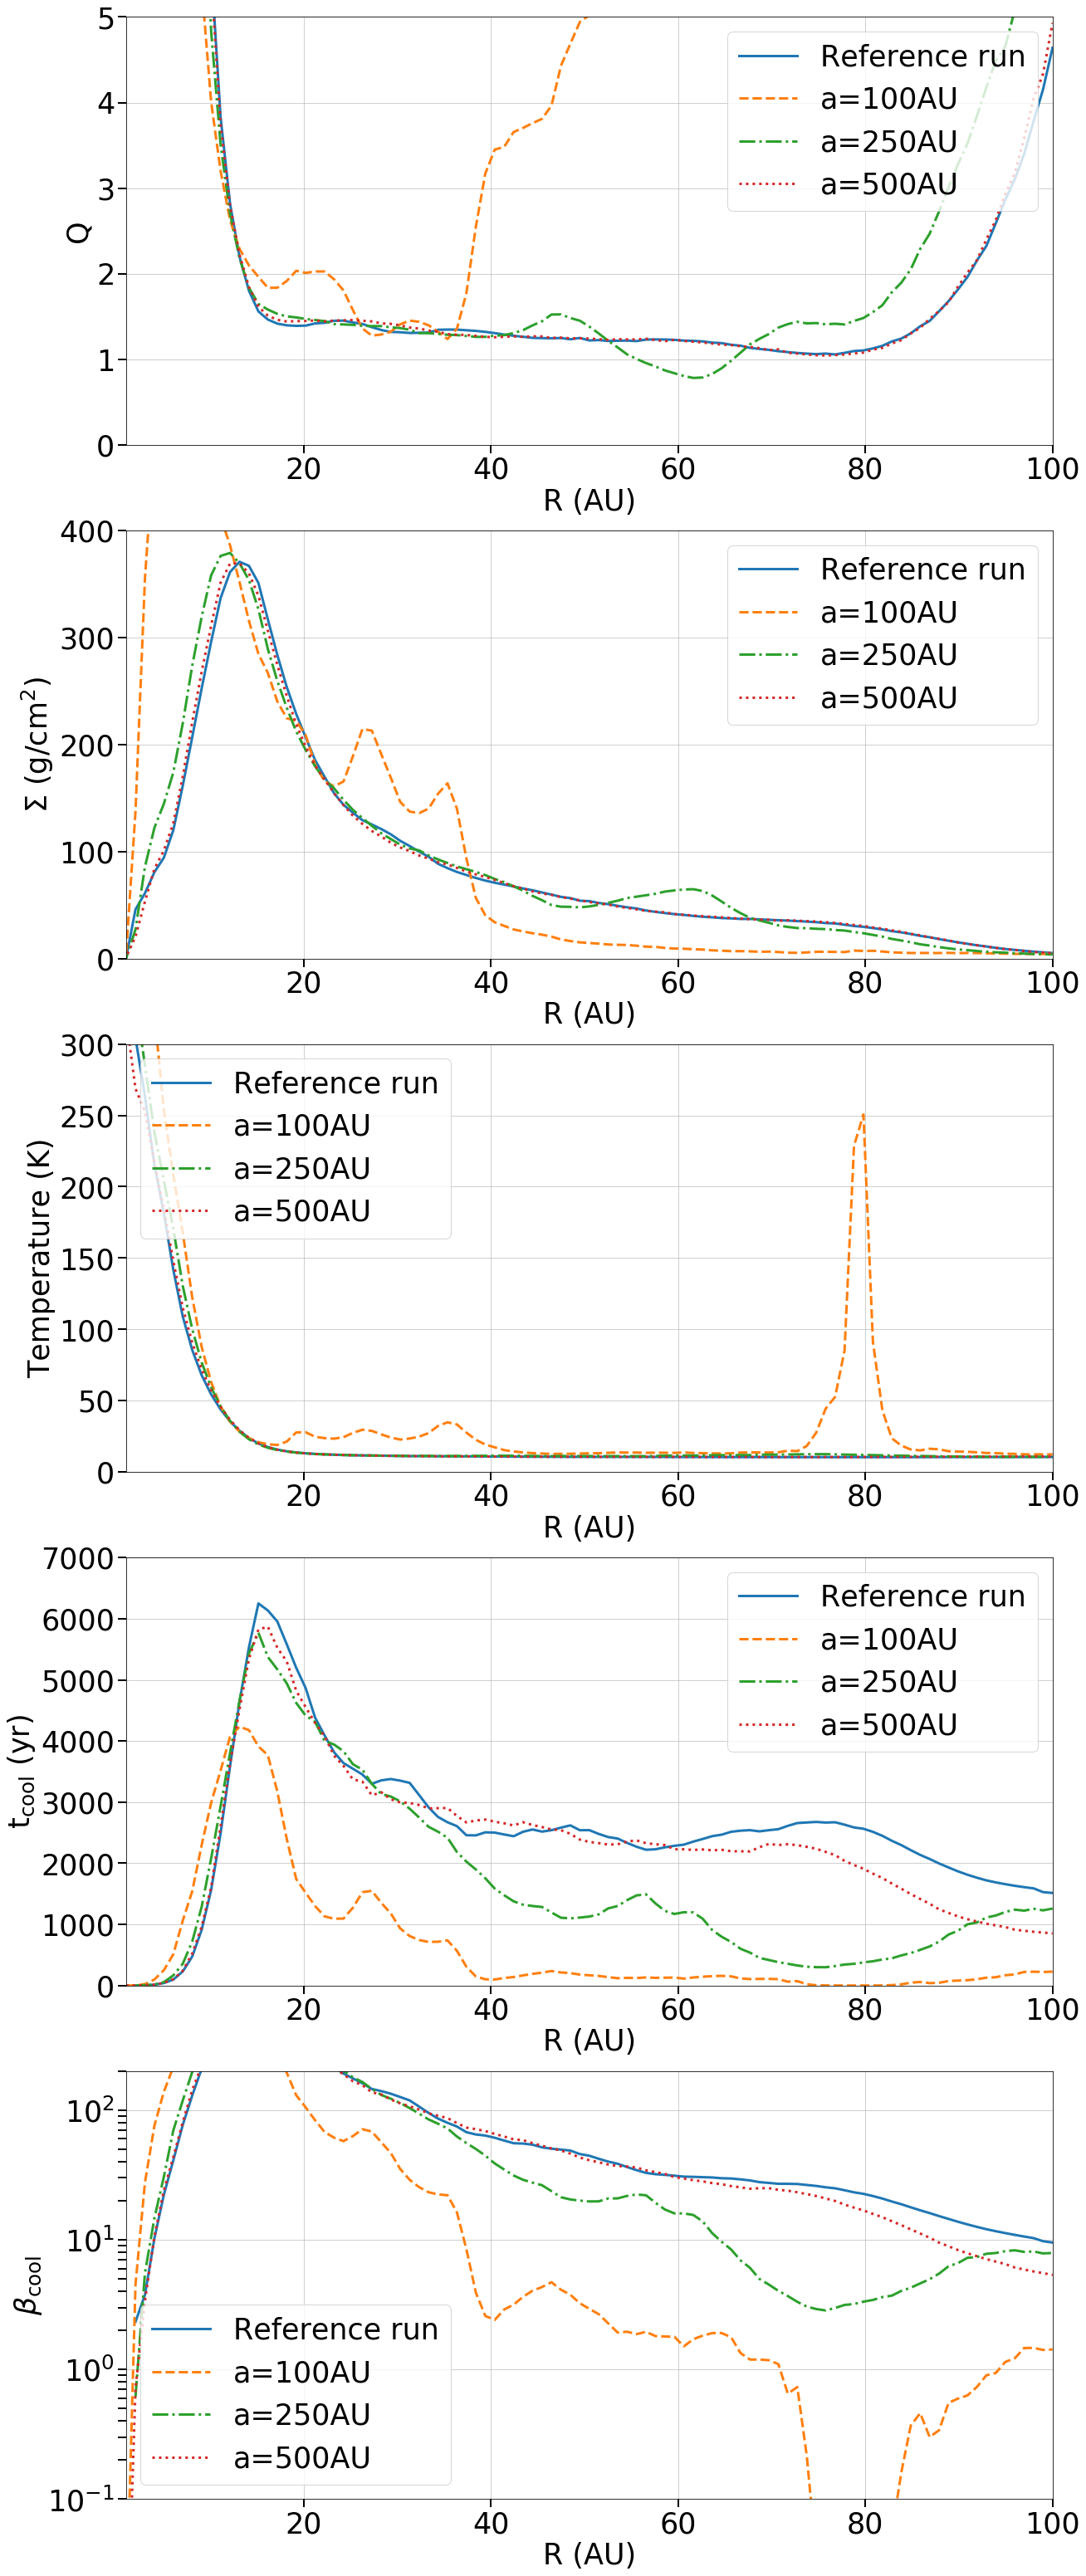

In [12]:
# plot the results
legend = ['Reference run', 'a=100AU', 'a=250AU', 'a=500AU']

dumps_to_plot = [
 '../single/mdisc0.2/sgdisc_00050',
 '../a100/mdisc0.2/extra_dumps/sgdisc_00004',
 '../a250/mdisc0.2/extra_dumps/sgdisc_00026',
 '../a500/mdisc0.2/extra_dumps/sgdisc_00090'
]

pyphantom_dicts_to_plot = [pyphantom_dicts[dump] for dump in dumps_to_plot]
fig,ax = plt.subplots(5,1,figsize=(20,55))
for i,key in enumerate(['toomre','sigma','temp','tcool','beta']):
    ax[i] = plot_multidumps_subplots(pyphantom_dicts_to_plot,plots_stuff,key,legend,ax[i])

plt.savefig('../1D_plots/a250_vs_referencerun.png',bbox_inches='tight')
plt.show()